In [7]:
from pathlib import Path
from tqdm import trange

import torch
import torch.nn.functional as F

import taichi as ti

from differender.volume_raycaster import Raycaster, Mode
from differender.utils import get_rand_pos, in_circles, get_tf

from torchvtk.datasets import TorchDataset
from torchvtk.utils import TFGenerator, tex_from_pts, make_4d
from torchvtk.rendering import show_tf, plot_tf, plot_comp_render_tf

import matplotlib.pyplot as plt

[Taichi] version 0.8.1, llvm 10.0.0, commit cc2dd342, linux, python 3.9.7
[TaiGLSL] version 0.0.11


In [230]:
def show_im(im, axs=None):
    if axs is None:
        fig, axs = plt.subplot_mosaic([['rgb', 'alpha', 'wysiwyp'],
                                        ['depth1', 'depth2', 'depth3'],
                                        ['alpha1', 'alpha2', 'alpha3'],
                                        ['sorted1','sorted2','sorted3'],
                                        ['diff1','diff2','diff3']], figsize=(15,25))
    axs['rgb'].imshow(im.squeeze()[:3].permute(1,2,0).cpu().numpy())
    axs['rgb'].set_title('Color')
    axs['rgb'].set_axis_off()
    axs['alpha'].imshow(im.squeeze()[[3,3,3]].permute(1,2,0).cpu().numpy())
    axs['alpha'].set_title('Alpha')
    axs['alpha'].set_axis_off()
    axs['wysiwyp'].imshow(im.squeeze()[[4]].permute(1,2,0).cpu().numpy())
    axs['wysiwyp'].set_title('WYSIWYP')
    axs['wysiwyp'].set_axis_off()    
    
    axs['depth1'].imshow(im.squeeze()[[4]].permute(1,2,0).cpu().numpy())
    axs['depth1'].set_title('Interval 1')
    axs['depth1'].set_axis_off()
    axs['depth2'].imshow(im.squeeze()[[5]].permute(1,2,0).cpu().numpy())
    axs['depth2'].set_title('Interval 2')
    axs['depth2'].set_axis_off()
    axs['depth3'].imshow(im.squeeze()[[6]].permute(1,2,0).cpu().numpy())
    axs['depth3'].set_title('Interval 3')
    axs['depth3'].set_axis_off()
    axs['alpha1'].imshow(im.squeeze()[[7]].permute(1,2,0).cpu().numpy())
    axs['alpha1'].set_title('Alpha at I1')
    axs['alpha1'].set_axis_off()
    axs['alpha2'].imshow(im.squeeze()[[8]].permute(1,2,0).cpu().numpy())
    axs['alpha2'].set_title('Alpha at I2')
    axs['alpha2'].set_axis_off()
    axs['alpha3'].imshow(im.squeeze()[[9]].permute(1,2,0).cpu().numpy())
    axs['alpha3'].set_title('Alpha at I3')
    axs['alpha3'].set_axis_off()

    
    sorted_depth, idx = rgbad[4:7].sort(dim=0)
    axs['sorted1'].imshow(sorted_depth[[0]].permute(1,2,0).cpu().numpy())
    axs['sorted1'].set_title('Sorted Depth 1')
    axs['sorted1'].set_axis_off()
    axs['sorted2'].imshow(sorted_depth[[1]].permute(1,2,0).cpu().numpy())
    axs['sorted2'].set_title('Sorted Depth 2')
    axs['sorted2'].set_axis_off()
    axs['sorted3'].imshow(sorted_depth[[2]].permute(1,2,0).cpu().numpy())
    axs['sorted3'].set_title('Sorted Depth 3')
    axs['sorted3'].set_axis_off()
    
    if 'diff1' in axs:
        diff1 = sorted_depth[1] - sorted_depth[0]
        diff2 = sorted_depth[2] - sorted_depth[1]
        diff3 = sorted_depth[2] - sorted_depth[0]
        axs['diff1'].imshow(diff1[None].permute(1,2,0).cpu().numpy())
        axs['diff1'].set_title('Sorted 2 - 1')
        axs['diff1'].set_axis_off()
        axs['diff2'].imshow(diff2[None].permute(1,2,0).cpu().numpy())
        axs['diff2'].set_title('Sorted 3 - 2')
        axs['diff2'].set_axis_off()
        axs['diff3'].imshow(diff3[None].permute(1,2,0).cpu().numpy())
        axs['diff3'].set_title('Sorted 3 - 1')
        axs['diff3'].set_axis_off()
    
    
def show_hist(im, ax=None, title='Histogram', show_percentages=True):
    tit = f'{title}'
    x = torch.linspace(0.0, 1.0, BINS)
    hst = torch.histc(im, BINS, min=0.0, max=1.0).cpu()
    
    if show_percentages:
        tit = f'{tit}: Transparent: {hst[1:-1].sum()/im.numel():.1%}'
        tit = f'{tit} | Opaque: {hst[-1]/im.numel():.1%}'
        tit = f'{tit} | Visible: {1.0 - hst[0]/im.numel():.1%}'
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(5,5))
        fig.title(tit)
    else:
        ax.set_title(tit)
    
    ax.bar(x, hst, width=1/BINS)
    

In [231]:
def show_all_ims(render):
    fig, ax = plt.subplot_mosaic([['full_rgb', 'full_a', 'full_d'],
                                  ['l1_rgb', 'l1_a', 'l1_d'],
                                  ['l2_rgb', 'l2_a', 'l2_d'],
                                  ['l3_rgb', 'l3_a', 'l3_d'],
                                 ], figsize=(15,20))
    ax['full_rgb'].imshow(render[:3].permute(1,2,0))
    ax['full_rgb'].set_title('Full RGB')
    ax['full_rgb'].set_axis_off()
    ax['full_a'].imshow(render[[3]].permute(1,2,0))
    ax['full_a'].set_title('Full Alpha')
    ax['full_a'].set_axis_off()
    ax['full_d'].imshow(render[[4]].permute(1,2,0))
    ax['full_d'].set_title('Full Depth')
    ax['full_d'].set_axis_off()
    
    ax['l1_rgb'].imshow(render[7:10].permute(1,2,0))
    ax['l1_rgb'].set_title('Layer 1 RGB')
    ax['l1_rgb'].set_axis_off()
    ax['l1_a'].imshow(render[[10]].permute(1,2,0))
    ax['l1_a'].set_title('Layer 1 Alpha')
    ax['l1_a'].set_axis_off()
    ax['l1_d'].imshow(render[[4]].permute(1,2,0))
    ax['l1_d'].set_title('Layer 1 Depth')
    ax['l1_d'].set_axis_off()
    
    ax['l2_rgb'].imshow(render[11:14].permute(1,2,0))
    ax['l2_rgb'].set_title('Layer 2 RGB')
    ax['l2_rgb'].set_axis_off()
    ax['l2_a'].imshow(render[[14]].permute(1,2,0))
    ax['l2_a'].set_title('Layer 2 Alpha')
    ax['l2_a'].set_axis_off()
    ax['l2_d'].imshow(render[[5]].permute(1,2,0))
    ax['l2_d'].set_title('Layer 2 Depth')
    ax['l2_d'].set_axis_off()
    
    ax['l3_rgb'].imshow(render[15:18].permute(1,2,0))
    ax['l3_rgb'].set_title('Layer 3 RGB')
    ax['l3_rgb'].set_axis_off()
    ax['l3_a'].imshow(render[[18]].permute(1,2,0))
    ax['l3_a'].set_title('Layer 3 Alpha')
    ax['l3_a'].set_axis_off()
    ax['l3_d'].imshow(render[[6]].permute(1,2,0))
    ax['l3_d'].set_title('Layer 3 Depth')
    ax['l3_d'].set_axis_off()

In [224]:
def composite_layers(layers):
    ''' Composites SORTED (batch of) RBAD layers

    Args:
        layers (torch.Tensor): ([BS,] L, 4+, H, W) RGBAD image stack of L layers, sorted by depth, can have more than RGBA channels, but they are ignored

    Returns:
        torch.Tensor: ([BS,], 4, H, W) (batch of) RGBA composited render
    '''
    l_dim, c_dim = layers.ndim - 4, layers.ndim - 3
    l_size = layers.size(l_dim)
    devdtype = {'dtype': layers.dtype, 'device': layers.device}

    shap_rgb = (*layers.shape[:-3], 3, *layers.shape[-2:])
    shap_a   = (*layers.shape[:-3], 1, *layers.shape[-2:])
    # Shapes are ([BS,] L, 3, H, W) and ([BS,], L, 1, H, W)
    acc_rgb, acc_a = torch.zeros(*shap_rgb, **devdtype), torch.zeros(*shap_a, **devdtype)
    acc_rgb[..., 0, :,:,:] = layers[..., 0,  :3, :,:]
    acc_a[  ..., 0, :,:,:] = layers[..., 0, [3], :,:]
    for i in range(1, l_size):
        #                                   old acc       +           (1 - a)              *          Alpha           *          Color
        acc_rgb[..., i, :,:,:] = acc_rgb[..., i-1, :,:,:] + (1.0 - acc_a[..., i-1, :,:,:]) * layers[..., i, [3], :,:] * layers[..., i, :3, :,:]
        acc_a[  ..., i, :,:,:]   = acc_a[..., i-1, :,:,:] + (1.0 - acc_a[..., i-1, :,:,:]) * layers[..., i, [3], :,:]
    acc_rgba = torch.cat([acc_rgb[..., -1, :,:,:], acc_a[..., -1, :,:,:]], dim=c_dim-1) # Layer dim is removed, thus c_dim -1
    return torch.clamp(acc_rgba, 0.0, 1.0)

def add_alpha_layer(t):
    return torch.cat([t, torch.ones_like(t[[0]])], dim=0)

In [218]:
N_ITEMS = 100000
W, H = 512, 512
TF_RES = 256
BINS = 51
SR = 16.0 # Sampling rate
MODE = Mode.WYSIWYP

out_dir = Path('/run/media/dome/Data/data/STDepth_data_multi_wys3')

#ds = TorchDataset('/mnt/hdd/shared_datasets/torchvtk/CQ500')
ds = TorchDataset('/run/media/dome/Data/data/torchvtk/CQ500')
N_VOLUMES = len(ds)

In [219]:
tfgen = TFGenerator(colors='distinguishable', peakgen_kwargs={
    'max_num_peaks': (2,3),
    'height_range': (0.02, 0.4),
    'width_range': (0.005, 0.05),
    'use_hist': False
})

In [ ]:
raycaster = None
skips = 0
visibilities = []
for v in trange(0, N_VOLUMES):
    item = ds[v]
    vol = make_4d(item['vol']).float().to('cuda')
    nam = item['name']
    ti.reset()
    del raycaster
    raycaster = Raycaster(vol.shape[-3:], (W, H), TF_RES, mode=MODE,
        sampling_rate=SR, near=0.1, far=5.0, max_samples=1, ti_kwargs={'device_memory_fraction':0.5})
    for i in trange(N_ITEMS // N_VOLUMES):
        fn = out_dir/f'{nam}_{i}.pt'
        if fn.exists(): continue
        while True:
            lf = get_rand_pos(1).float().to('cuda')
            tf = tex_from_pts(tfgen.generate(), TF_RES).float().to('cuda')
            rgbad = raycaster.raycast_nondiff(vol, tf, lf, sampling_rate=SR, layer_dist_thresh=2e-2).squeeze(0)
            hst = torch.histc(rgbad[3], BINS, min=0.0, max=1.0)
            vis = hst[1:-1].sum()/rgbad[3].numel() # Visibility as in % of pixels with 0.02 < a < 0.9
            if (rgbad[3] > 0.0).float().mean() < 0.1:
                skips += 1
                #print(f'Skipping another useless render ({skips})')
                continue
            elif vis < 0.2:
                skips += 1
                #print(f'Skipping another too transparent render ({skips})')
                continue
            else:
                visibilities.append(vis.cpu().float())
                full = torch.clamp(rgbad[:4], 0.0, 1.0)
                full = composite_layers(torch.stack([
                    full, 
                    add_alpha_layer(
                        generate_background_for(full[[0]]).expand(3,-1,-1))
                ]))
                layer1 = torch.cat([rgbad[7:11],  rgbad[[4]]], dim=0)
                layer2 = torch.cat([rgbad[11:15], rgbad[[5]]], dim=0)
                layer3 = torch.cat([rgbad[15:19], rgbad[[6]]], dim=0)

                back = (full - layer1[:4]) / (1.0 - layer1[3])
                back[:3] = torch.nan_to_num(back[:3] / back[3])
                back = torch.clamp(back, 0.0, 1.0)
                torch.save({
                    'vol': nam,
                    'tf': tf.squeeze(0).cpu().float(),
                    'look_from': lf.squeeze(0).cpu().float(),
                    'rgba': full.cpu().half(),
                    'back': back.cpu().half(),
                    'layer1': layer1.cpu().half(),
                    'layer2': layer2.cpu().half(),
                    'layer3': layer3.cpu().half(),
                    'visibility': vis.cpu().float()
                }, fn)
                break
        #break
    #break
print(f'Average visibility in the dataset: {torch.stack(visibilities).mean():.1%}')

  0%|          | 0/395 [00:00<?, ?it/s]

[Taichi] Starting on arch=cuda



 62%|██████▏   | 156/253 [12:17<05:32,  3.43s/it]


  0%|          | 1/395 [20:25<134:05:44, 1225.24s/it]

[Taichi] Starting on arch=cuda



 61%|██████▏   | 155/253 [13:42<08:00,  4.90s/it]


  1%|          | 2/395 [42:28<140:01:10, 1282.62s/it]

[Taichi] Starting on arch=cuda



 61%|██████▏   | 155/253 [12:08<07:29,  4.59s/it]


  1%|          | 3/395 [1:02:20<135:09:56, 1241.32s/it]

[Taichi] Starting on arch=cuda



 61%|██████▏   | 155/253 [07:57<04:59,  3.06s/it]


  1%|          | 4/395 [1:15:00<114:11:26, 1051.37s/it]

[Taichi] Starting on arch=cuda



 61%|██████▏   | 155/253 [11:34<05:38,  3.46s/it]


  1%|▏         | 5/395 [1:33:55<117:09:58, 1081.53s/it]

[Taichi] Starting on arch=cuda



 61%|██████▏   | 155/253 [10:16<09:39,  5.91s/it]


  2%|▏         | 6/395 [1:50:54<114:34:35, 1060.35s/it]

[Taichi] Starting on arch=cuda



 61%|██████▏   | 155/253 [09:02<07:31,  4.61s/it]


  2%|▏         | 7/395 [2:05:55<108:38:59, 1008.09s/it]

[Taichi] Starting on arch=cuda



 61%|██████▏   | 155/253 [11:04<04:50,  2.96s/it]


  2%|▏         | 8/395 [2:24:01<111:02:43, 1032.98s/it]

[Taichi] Starting on arch=cuda



 61%|██████▏   | 155/253 [12:58<10:11,  6.24s/it]


  2%|▏         | 9/395 [2:44:29<117:17:06, 1093.85s/it]

[Taichi] Starting on arch=cuda



 61%|██████▏   | 155/253 [07:46<04:16,  2.61s/it]


  3%|▎         | 10/395 [2:57:43<107:05:45, 1001.42s/it]

[Taichi] Starting on arch=cuda



 61%|██████▏   | 155/253 [11:38<10:15,  6.28s/it]


  3%|▎         | 11/395 [3:15:41<109:18:47, 1024.81s/it]

[Taichi] Starting on arch=cuda



 61%|██████▏   | 155/253 [10:38<04:52,  2.98s/it]


  3%|▎         | 12/395 [3:33:05<109:39:01, 1030.66s/it]

[Taichi] Starting on arch=cuda



 61%|██████▏   | 155/253 [11:35<08:13,  5.03s/it]


  3%|▎         | 13/395 [3:54:55<118:20:59, 1115.34s/it]

[Taichi] Starting on arch=cuda



 61%|██████▏   | 155/253 [09:19<07:45,  4.75s/it]


  4%|▎         | 14/395 [4:10:18<111:52:47, 1057.13s/it]

[Taichi] Starting on arch=cuda



 61%|██████▏   | 155/253 [09:37<07:04,  4.33s/it]


  4%|▍         | 15/395 [4:25:30<106:57:42, 1013.32s/it]

[Taichi] Starting on arch=cuda



 61%|██████▏   | 155/253 [13:02<07:05,  4.34s/it]


  4%|▍         | 16/395 [4:45:32<112:39:54, 1070.17s/it]

[Taichi] Starting on arch=cuda



 61%|██████▏   | 155/253 [09:38<06:13,  3.81s/it]


  4%|▍         | 17/395 [5:01:17<108:26:04, 1032.71s/it]

[Taichi] Starting on arch=cuda



 61%|██████▏   | 155/253 [09:57<07:53,  4.83s/it]


  5%|▍         | 18/395 [5:17:20<105:56:09, 1011.59s/it]

[Taichi] Starting on arch=cuda



 61%|██████▏   | 155/253 [10:38<04:37,  2.83s/it]


  5%|▍         | 19/395 [5:34:15<105:46:55, 1012.81s/it]

[Taichi] Starting on arch=cuda



 61%|██████▏   | 155/253 [11:33<10:23,  6.36s/it]


  5%|▌         | 20/395 [5:52:53<108:46:29, 1044.24s/it]

[Taichi] Starting on arch=cuda



 61%|██████▏   | 155/253 [09:31<06:15,  3.83s/it]


  5%|▌         | 21/395 [6:09:25<106:50:48, 1028.47s/it]

[Taichi] Starting on arch=cuda



 61%|██████▏   | 155/253 [15:23<07:38,  4.68s/it]


 71%|███████   | 179/253 [17:45<08:56,  7.25s/it]

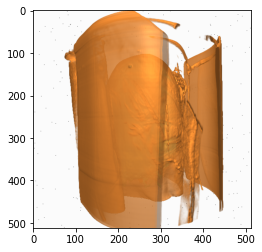

In [238]:
plt.imshow(full.cpu().permute(1,2,0))

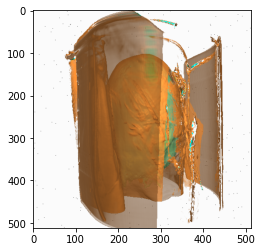

In [239]:
plt.imshow(back.cpu().permute(1,2,0))

In [9]:
!mkdir /run/media/dome/Data/data/STDepth_data_multi_wys3 

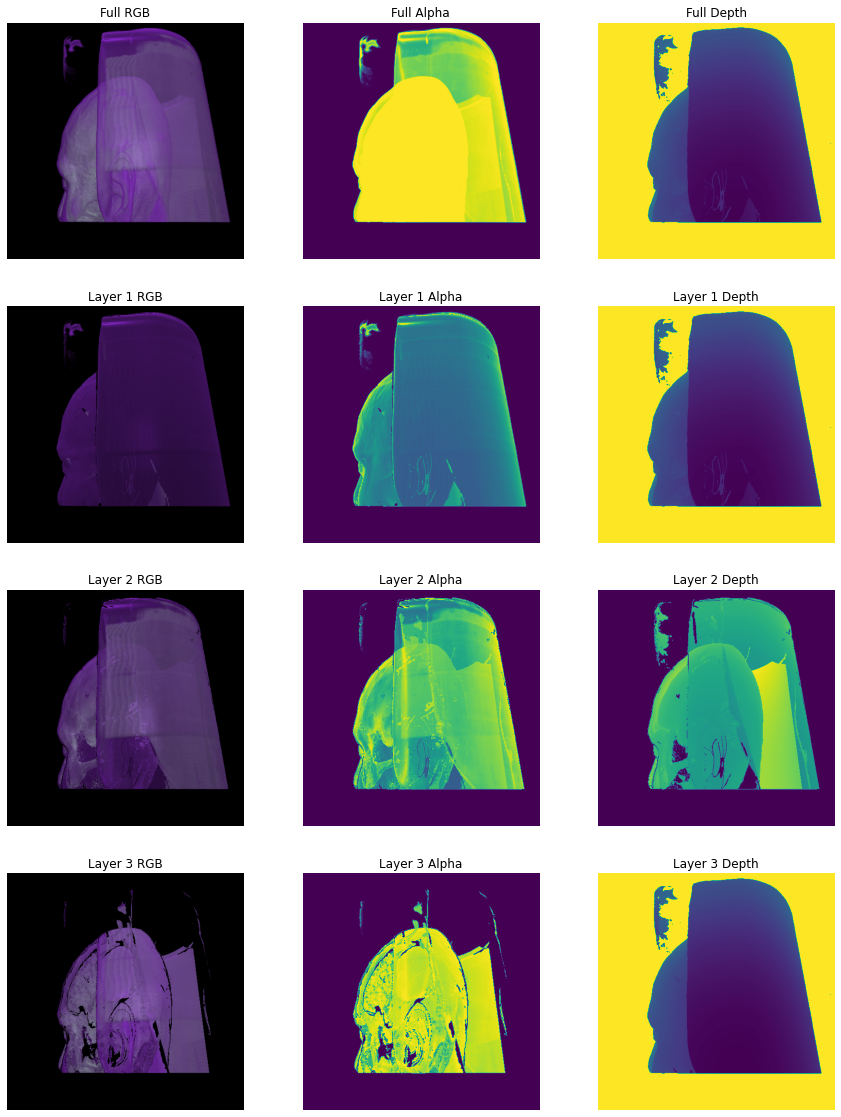

In [234]:
show_all_ims(rgbad.cpu())

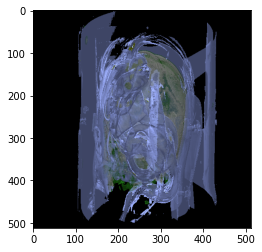

In [45]:
plt.imshow(back[:3].cpu().permute(1,2,0))

In [ ]:
rgbad1 = raycaster.raycast_nondiff(vol, tf, lf, sampling_rate=SR, mode=Mode.MIDA, layer_dist_thresh=1e-2).squeeze(0)
#rgbad2 = raycaster.raycast_nondiff(vol, tf, lf, sampling_rate=SR, mode=Mode.WYSIWYP).squeeze(0)
print((rgbad[7:10] == rgbad[15:18]).all(), (rgbad[10] == rgbad[18]).all())
show_all_ims(rgbad1.cpu())
#show_all_ims(rgbad2.cpu())

In [ ]:
##### BACKGROUND STUFF

In [221]:
def split_squeeze(t):
    X, Y, Z = t.split(1, dim=-1)
    return (X.squeeze(-1), Y.squeeze(-1), Z.squeeze(-1))

ONE = torch.ones(1)
def add_salt_pepper(t, n_salt, n_pepper=None):
    if not n_pepper: n_pepper = n_salt
    indices = torch.ones_like(t).nonzero()
    idx = indices[torch.multinomial(ONE.expand(indices.size(0)), n_salt + n_pepper)]
    t[split_squeeze(idx[:n_pepper])] = 0
    t[split_squeeze(idx[n_pepper:])] = 1
    return t

def generate_background_for(t, black_thresh=0.05, white_thresh=0.95, n_salt=250, n_pepper=250):
    dev, dtyp = t.device, t.dtype
    if torch.rand(1) > 0.5:
        bg = torch.ones_like(t) * (torch.rand(1, device=dev, dtype=dtyp) * (1.0 - white_thresh) + white_thresh)
    else:
        bg = torch.zeros_like(t) * (torch.rand(1, device=dev, dtype=dtyp) * black_thresh)
    return add_salt_pepper(bg, n_salt, n_pepper)

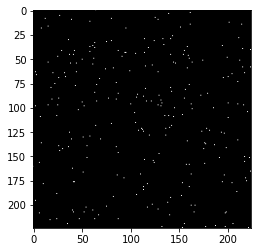

In [215]:
plt.imshow(generate_background_for(torch.ones(224,224,1)).expand(224,224,3))

In [22]:
torch.ones(224,224)[split_squeeze(idx[:200])].shape

torch.Size([200])

In [27]:
F.normalize(torch.randn(1000000, 16), dim=1).std()

tensor(0.2500)

In [25]:
idx.shape

torch.Size([200, 2])

In [26]:
indices.shape

torch.Size([50176, 2])

In [23]:
split_squeeze(idx[:200])

(tensor([191,  57,  73, 156,   5, 218, 107,  93,  46, 211, 123,  15,  14, 192,
         108, 210, 122, 121, 104,  49, 136, 118, 104, 107,  76,  39, 142,  22,
         141, 204,  24,  25, 223, 105, 131,   5, 142, 207,  56, 202, 176, 144,
         138,  43,   4,  33,  13, 176, 145, 135,  41,  83, 214, 187,  48, 193,
          71, 142,  19,  59, 122, 214, 223, 187,  10, 139,  30,  20,  40,  74,
          57, 204,  88, 151,  81,  82, 159, 187, 105,  89, 160, 143,  12,  10,
         223,  50, 204,  69, 119,  10,  79,  52, 191,  34, 111, 118, 130, 150,
         177, 158,   1, 166, 116,   3,  19,  65,  87, 153,  94, 173,  22,  94,
         120, 100,  95, 196, 112,  58, 161, 212, 121, 104,  18,  67, 154,  28,
          40,   3,  91, 160, 204,   1, 140, 174,  30,   9,  43, 217, 199, 108,
         116, 160,  61, 115,  54, 154, 100, 130, 168, 182, 135, 126, 154, 207,
           6, 219, 179, 151,  55,   6,  66,  37,  52, 133,  73, 202, 209, 166,
          15, 222,  73, 217, 113,  28, 134, 121, 207

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


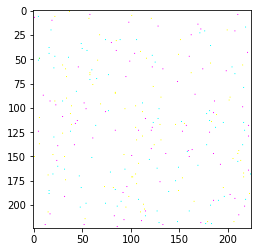

In [18]:
plt.imshow(generate_background_for(torch.ones(224,224,3)))

In [1]:
plt.imshow(add_salt_pepper(torch.ones(224,224,3)*0.9, 200))

NameError: name 'plt' is not defined

In [24]:
bg = torch.ones(224,224)
indices = torch.ones_like(bg).nonzero()
idx = indices[torch.multinomial(ONE.expand(indices.size(0)), 200)]
bg[split_squeeze(idx)] = 0
plt.imshow(bg)

ValueError: not enough values to unpack (expected 3, got 2)

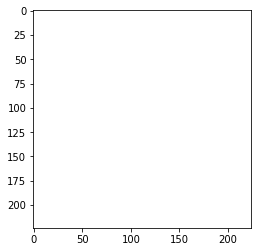

In [13]:
plt.imshow(torch.ones(224,224,3))

In [ ]:
(raycaster.vr.exit[100,100] - raycaster.vr.entry[100,100]) / raycaster.vr.sample_step_nums[100,100]

In [ ]:
lf = get_rand_pos(1).float().to('cuda')
tf = tex_from_pts(tfgen.generate(), TF_RES).float().to('cuda')

In [ ]:
full = rgbad1[:4]
layer1 = torch.cat([rgbad1[7:11],  rgbad1[[4]]], dim=0)
layer2 = torch.cat([rgbad1[11:15], rgbad1[[5]]], dim=0)
layer3 = torch.cat([rgbad1[15:19], rgbad1[[6]]], dim=0)
stac = torch.stack([layer1, layer2, layer3])

In [ ]:
val, idx = torch.sort(stac[:, 4], dim=0, stable=True)

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(val[0].cpu())
ax[1].imshow(val[1].cpu())
ax[2].imshow(val[2].cpu())
fig.show()

In [ ]:
stac.shape, idx.shape

In [ ]:
idx.shape

In [ ]:
stac[:,0].shape

In [ ]:
sorted_stac = torch.stack([stac[:, i].gather(dim=0, index=idx) for i in range(stac.size(1))], dim=1)

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(sorted_stac[0, [4]].permute(1,2,0).cpu())
ax[1].imshow(sorted_stac[1, [4]].permute(1,2,0).cpu())
ax[2].imshow(sorted_stac[2, [4]].permute(1,2,0).cpu())
fig.show()

In [ ]:
a = torch.rand(2, 3, 3)
b = torch.zeros_like(a)
i = torch.argsort(a, dim=0)
a.shape, i.shape

In [ ]:
a_sort, _ = a.sort(dim=0)

In [ ]:
a, i

In [ ]:
a_sort

In [ ]:
a[0][i[0]]

In [ ]:
red[idx].shape

In [ ]:
sortstac = stac.permute(1,0,2,3)[:, idx]

In [ ]:
stac.shape

In [ ]:
sortstac = stac.permute(1,0,2,3).cpu()[:, idx]

In [ ]:
back1 = (full - layer1[4] * layer1[:4]) / (1.0 - layer1[4])

In [ ]:
plt.imshow(back1[[3]].permute(1,2,0).cpu())

In [ ]:
plt.imshow(layer1[:3].permute(1,2,0).cpu())

In [ ]:
lt = 5e-3
rgbad1 = raycaster.raycast_nondiff(vol[None], tf, lf, sampling_rate=SR, mode=Mode.MIDA, 
        layer_dist_thresh=lt).squeeze(0)
rgbad2 = raycaster.raycast_nondiff(vol[None], tf, lf, sampling_rate=SR, mode=Mode.WYSIWYP,            
        layer_dist_thresh=lt).squeeze(0)

show_all_ims(rgbad1.cpu())
show_all_ims(rgbad2.cpu())

In [ ]:
rgbad = raycaster.raycast_nondiff(vol, tf, lf, sampling_rate=SR, mode=Mode.WYSIWYP).squeeze(0)
show_all_ims(rgbad.cpu())

In [ ]:
tf = tfgen.generate()
while len(tf) == 8: # single peak
    tf = tfgen.generate()
n_peaks = (len(tf)-2)//6
single_peaks = []
for i in range(n_peaks):
    peak = torch.cat([tf[[0]], tf[6*i+1 : 6*(i+1)+1], tf[[-1]]], dim=0)
    single_peaks.append({'pts': peak, 'tex': tex_from_pts(peak, TF_RES)})
    
rgbad_full = raycaster.raycast_nondiff(vol.float().cuda(), tex_from_pts(tf, TF_RES).float().cuda(),
                                       lf.float().cuda(), sampling_rate=SR).squeeze(0).detach().cpu()
#rgbad_full[4:][(rgbad_full[4:] == 0.0)] = 1.0
show_im(rgbad_full)
print((rgbad_full[3] > 0.0).float().mean())

single_peak_renders = []
for p in single_peaks:
    rgbad = raycaster.raycast_nondiff(vol.float().cuda(), p['tex'].float().cuda(), 
                                      lf.float().cuda(), sampling_rate=SR).squeeze(0)
    
    rgbad[4:][(rgbad[4:] == 0.0)] = 1.0
    
    single_peak_renders.append(rgbad.detach().cpu())
    fig, ax = plt.subplot_mosaic([['hist', 'hist', 'tf1'], 
                                  ['hist', 'hist', 'tf2'], 
                                  ['rgb', 'alpha', 'wysiwyp'],
                                  ['depth1', 'depth2', 'depth3'],
                                  ['alpha1', 'alpha2', 'alpha3'],
                                  ['sorted1', 'sorted2', 'sorted3']], figsize=(15,25), gridspec_kw={
        'width_ratios': [1.0, 1.0, 1.0], 'height_ratios': [0.5, 0.5, 1.0, 1.0, 1.0, 1.0]
    })
    show_hist(rgbad[3], ax['hist'], title='Alpha Histogram')
    show_tf(p['pts'], ax=ax['tf1'], title='Current TF Peak')
    show_tf(tf, ax=ax['tf2'], title='Full Transfer Function')
    show_im(rgbad, axs=ax)
    
    fig.show()

for r, p in zip(single_peak_renders, single_peaks):
    abs_diff = torch.abs(r[:4] - rgbad_full[:4])
    abs_ddif = torch.abs(r[[4]] - rgbad_full[[4]])
    mae = abs_diff.mean()
    pct = (abs_diff.max(dim=0).values > 0.1).float().mean().item()
    fig, ax = plt.subplot_mosaic([['single', 'full', 'diff'],
                                  ['sdepth', 'fdepth', 'ddepth'],
                                  ['salpha', 'falpha', 'dalpha'],
                                  ['tf1', 'tf2', 'hist']], figsize=(15,12), gridspec_kw={
        'width_ratios': [1.0, 1.0, 1.0], 'height_ratios': [5.0, 5.0, 5.0, 2.0]
    })
    ax['single'].imshow(r[:3].permute(1,2,0))
    ax['single'].set_title('Partial RGB')
    ax['single'].set_axis_off()
    
    ax['full'].imshow(rgbad_full[:3].permute(1,2,0))
    ax['full'].set_title('Full RGB')
    ax['full'].set_axis_off()
    ax['diff'].imshow(abs_diff[:3].permute(1,2,0))
    ax['diff'].set_title(f'Abs RGB Difference. Pct: {pct:.1%}')
    ax['diff'].set_axis_off()
    
    ax['sdepth'].imshow(r[[4,4,4]].permute(1,2,0))
    ax['sdepth'].set_title('Partial Depth')
    ax['sdepth'].set_axis_off()
    ax['fdepth'].imshow(rgbad_full[[4,4,4]].permute(1,2,0))
    ax['fdepth'].set_title('Full Depth')
    ax['fdepth'].set_axis_off()
    ax['ddepth'].imshow(abs_ddif.permute(1,2,0))
    ax['ddepth'].set_title('Depth Difference')
    ax['ddepth'].set_axis_off()
    show_tf(p['pts'], ax=ax['tf1'], title='Partial TF')
    show_tf(tf, ax=ax['tf2'], title='Full TF')
    show_hist(abs_diff.max(dim=0).values, ax['hist'], title='Difference Histogram', show_percentages=False)
    
    fig.show()
    